## Dynamic properties in liquid Aluminium
This is an example of liquid aluminium.

Playing around with the parameters in the MD run ( system size, number of timesteps, dump frequency ) aswell as the parameters used when calling dynasor is recommend for optimal result.

Here, we use rather small system size, short trajectory few q-points etc to make the tutorial run faster.     
See the documentation for more comments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [2]:
from dynasor.trajectory import Trajectory
from dynasor.isotropic import generate_spherical_qpoints
from dynasor.correlation_functions import compute_dynamic_structure_factors
from dynasor.post_processing import compute_spherical_qpoint_average

In [3]:
# set log level
from dynasor.logging_tools import set_logging_level
set_logging_level('DEBUG')
set_logging_level('INFO')

### Setup the Trajectory
Here, we assume that the trajectory generated by lammps is named `lammpsrun/dump/dumpT1400.NVT.atom.velocity`.

Multiple different trajectory formats are supported (via internal readers, and via `mdanalysis` and `ase`), here we use the `trajectory_format='lammps_internal'`.

In [4]:
traj_fname = 'lammpsrun/dump/dumpT1400.NVT.atom.velocity'
frame_stop = 5000
traj = Trajectory(traj_fname, trajectory_format='lammps_internal', frame_stop=frame_stop)

INFO: Trajectory file: lammpsrun/dump/dumpT1400.NVT.atom.velocity
INFO: With a total of 2048 particles, 1 types.
INFO: X: 2048
INFO: Simulation cell is (nm):
[[3.4032 0.     0.    ]
 [0.     3.4032 0.    ]
 [0.     0.     3.4032]]


## Define q-points to sample

Here, we consider q-points on a 3D meshgrid upto a maximum of $|q|=20nm^{-1}$ with a maximum number of q-points set to 2000.


In [5]:
# setup q-points
q_max = 20
q_points = generate_spherical_qpoints(traj.cell, q_max=q_max, max_points=1000)

Histogram the q-points to show how many q-points we are sampling as a function of $|\mathbf{q}|$.

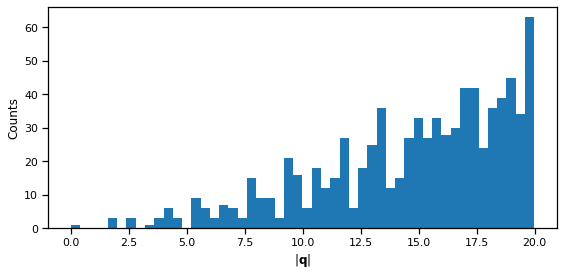

In [6]:

plt.figure(figsize=(8, 4))
plt.hist(np.linalg.norm(q_points, axis=1), bins=50)
plt.xlabel(r'$|\mathbf{q}|$')
plt.ylabel('Counts')
plt.tight_layout();

## Run dynamic structure factor calculation

Here `dt` must correspond to the time between to consecutive snapshots in the trajectory.

This may take a few minutes to run on a regular laptop.

Here, we also calculate current correlations (velocities correlations) by setting `include_currents=True`.

In [7]:
# time sampling parameters
delta_t = 25.0  # fs
window_size = 500
window_step = 50

# run 
sample_raw = compute_dynamic_structure_factors(traj, q_points, dt=delta_t,
                                               window_size=window_size, window_step=window_step, 
                                               calculate_currents=True)

INFO: Setting dt to 25.0 fs.
INFO: Setting time between consecutive frames (dt * frame_step) to 25.0 fs.
INFO: Time window is 12500.0 fs
INFO: delta_omega, max_omega = 0.0005026548245743669, 0.2513274122871834 fs^-1
INFO: Calculating current (velocity) correlations
INFO: N qpoints = 820


In [8]:
print(sample_raw)

Correlation function data:
Atom types: ['X']
Pair types: [('X', 'X')]
Particle counts: {'X': 2048}
Simulations cell:
[[3.4032 0.     0.    ]
 [0.     3.4032 0.    ]
 [0.     0.     3.4032]]
q_points     with shape: (820, 3)
t            with shape: (501,)
w            with shape: (501,)
F_q_t_X_X    with shape: (820, 501)
S_q_w_X_X    with shape: (820, 501)
F_q_t_coh    with shape: (820, 501)
S_q_w_coh    with shape: (820, 501)
Cl_q_t_X_X   with shape: (820, 501)
Ct_q_t_X_X   with shape: (820, 501)
Cl_q_w_X_X   with shape: (820, 501)
Ct_q_w_X_X   with shape: (820, 501)


### Spherical average over q-points
Conduct a spherical average over q-points



In [9]:
q_bins = 40
sample_averaged = compute_spherical_qpoint_average(sample_raw, q_bins)

### S(q, w) heatmap


In [10]:
# data
invfs2mev = 658.2119  # angular frequency
time = sample_averaged['t']
omega = invfs2mev * sample_averaged['w']
q_norms = sample_averaged['q_norms']
Sqw = sample_averaged['S_q_w_coh']
Fqt = sample_averaged['F_q_t_coh']

extent = [0, q_norms.max(), 0, omega.max()]

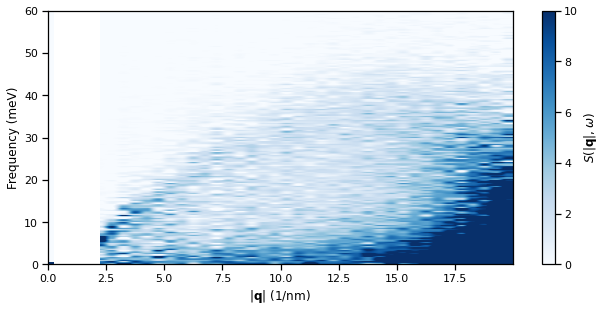

In [11]:
# plot heatmap
fig = plt.figure(figsize=(9, 4.5))

plt.imshow(Sqw.T, origin='lower', cmap='Blues', aspect='auto', extent=extent)
plt.colorbar(label='$S(|\mathbf{q}|, \omega)$')
plt.clim([0, 10])
plt.ylim([0, 60])

plt.xlabel('$|\mathbf{q}|$ (1/nm)')
plt.ylabel('Frequency (meV)')

fig.tight_layout()

### C(q, w) heatmaps (current correlations)
Here we plot the longitudinal and transverse current correlation heatmaps

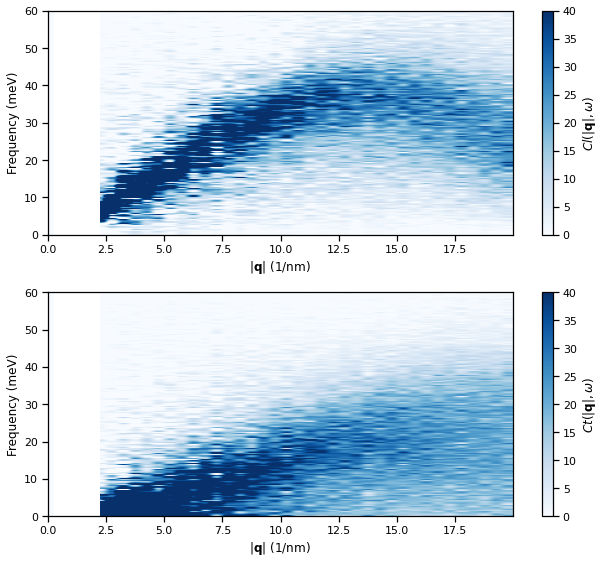

In [12]:
Clqt = sample_averaged['Cl_q_t_X_X']
Ctqt = sample_averaged['Ct_q_t_X_X']

Clqw = sample_averaged['Cl_q_w_X_X']
Ctqw = sample_averaged['Ct_q_w_X_X']

fig = plt.figure(figsize=(9, 8.0))

ax1 = fig.add_subplot(211)
plt.imshow(Clqw.T, origin='lower', cmap='Blues', aspect='auto', extent=extent)
plt.colorbar(label='$Cl(|\mathbf{q}|, \omega)$')
plt.clim([0, 40])
plt.ylim([0, 60])
plt.xlabel('$|\mathbf{q}|$ (1/nm)')
plt.ylabel('Frequency (meV)')


ax1 = fig.add_subplot(212)
plt.imshow(Ctqw.T, origin='lower', cmap='Blues', aspect='auto', extent=extent)
plt.colorbar(label='$Ct(|\mathbf{q}|, \omega)$')
plt.clim([0, 40])
plt.ylim([0, 60])
plt.xlabel('$|\mathbf{q}|$ (1/nm)')
plt.ylabel('Frequency (meV)')



fig.tight_layout()

### Slices in q-space

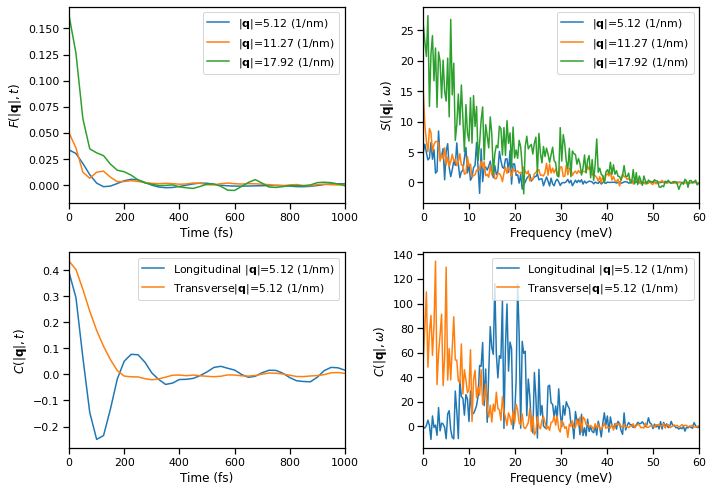

In [13]:
# slices in heatmap
q_inds = [10, 22, 35]

fig = plt.figure(figsize=(10, 7))

                 
# Fqt , Sqw                 
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
for q_ind in q_inds:
    label=fr'$|\mathbf{{q}}|$={q_norms[q_ind]:.2f} (1/nm)'
    ax1.plot(time, Fqt[q_ind, :], label=label)
    ax2.plot(omega, Sqw[q_ind, :], label=label)

ax1.legend(loc=1)
ax2.legend(loc=1)

ax1.set_xlabel('Time (fs)')
ax1.set_ylabel('$F(|\mathbf{q}|, t)$')
ax2.set_xlabel('Frequency (meV)')
ax2.set_ylabel('$S(|\mathbf{q}|, \omega)$')

ax1.set_xlim([0, 1000])
ax2.set_xlim([0, 60])


# Clqt , Clqw                 
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
q_ind = q_inds[0]
label=fr'$|\mathbf{{q}}|$={q_norms[q_ind]:.2f} (1/nm)'
ax3.plot(time, Clqt[q_ind, :], label='Longitudinal ' + label)
ax3.plot(time, Ctqt[q_ind, :], label='Transverse' + label)
ax4.plot(omega, Clqw[q_ind, :], label='Longitudinal ' + label)
ax4.plot(omega, Ctqw[q_ind, :], label='Transverse' + label)

ax3.legend(loc=1)
ax4.legend(loc=1)

ax3.set_xlabel('Time (fs)')
ax3.set_ylabel('$C(|\mathbf{q}|, t)$')
ax4.set_xlabel('Frequency (meV)')
ax4.set_ylabel('$C(|\mathbf{q}|, \omega)$')

ax3.set_xlim([0, 1000])
ax4.set_xlim([0, 60])                 
                 
fig.tight_layout()